# Bike sharing prediction project

### In this project, we have a dataset which contains the number of bike riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the 'cnt' column. The goal is to use the features from the dataset to predict the count of bike riders for a given observation. Here is the link of the dataset with a description of each of the columns: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn

from src.customizable_nn import FlexibleNeuralNetwork
from src.utils import create_data_loaders, split_train_validation_test, train_evaluate_model, evaluate_plot, evaluate_model

### read data

In [42]:
data_path = 'data/hour.csv'
rides = pd.read_csv(data_path)
rides['timestamp'] =pd.to_datetime(rides['dteday']) + pd.to_timedelta(rides['hr'], unit='h')

### one hot encoding

In [43]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False, dtype=float)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'mnth',  'hr', 'casual', 'registered'] # 'workingday', 'atemp', 
data = rides.drop(fields_to_drop, axis=1)
data.set_index('timestamp', inplace=True)

data.head(3)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,0,0.24,0.2879,0.81,0.0,16,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01 01:00:00,0,0,0,0.22,0.2727,0.80,0.0,40,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01 02:00:00,0,0,0,0.22,0.2727,0.80,0.0,32,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### split data

In [44]:
target_column = 'cnt'
X_train_val, y_train_val, X_test, y_test = split_train_validation_test(data, target_column, 0.9)
X_train, y_train, X_val, y_val = split_train_validation_test(pd.concat([X_train_val, y_train_val], axis=1), target_column, 0.9)

### normalize data

In [45]:
features = ['cnt', 'atemp', 'temp', 'hum', 'windspeed']
scaled_features = {}

train_data = pd.concat([X_train, y_train])
                       
for feature in features:
    mean, std = train_data[feature].mean(), train_data[feature].std()
    scaled_features[feature] = [mean, std]

scaled_features

{'cnt': [175.95183290707587, 168.1854041949148],
 'atemp': [0.480418975561239, 0.17694904307119466],
 'temp': [0.5019494174481387, 0.19819507192502706],
 'hum': [0.6232296106848536, 0.19782612203044667],
 'windspeed': [0.19364202188121626, 0.12281862735414112]}

In [46]:
for feature in scaled_features.keys():
    mean, std = scaled_features[feature]
    
    for dataset in [X_train, y_train, X_val, y_val, X_test]:
        if feature in dataset.columns:
            dataset[feature] = ((dataset[feature] - mean)/std)

### creat data loader

In [50]:
train_loader = create_data_loaders(X_train.values, y_train.values, 64)
val_loader = create_data_loaders(X_val.values, y_val.values, 64)
test_loader = create_data_loaders(X_test.values, y_test.values, 64)

### train & evaluate model

In [54]:
input_size = len(X_train.columns)
hidden_sizes = [12, 6]
output_size = 1
activations = ['relu', 'relu']

model = FlexibleNeuralNetwork(input_size, hidden_sizes, output_size, activations)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 5/40, Loss: 0.17792364020239224
Epoch 5/40, Val Loss: 0.36288397279825513
Epoch 10/40, Loss: 0.09393644843419845
Epoch 10/40, Val Loss: 0.19894744889039817
Epoch 15/40, Loss: 0.0750276737592437
Epoch 15/40, Val Loss: 0.15577921358333366
Epoch 20/40, Loss: 0.06757190820591694
Epoch 20/40, Val Loss: 0.14320502667158072
Epoch 25/40, Loss: 0.06407947853122922
Epoch 25/40, Val Loss: 0.1398017848497333
Epoch 30/40, Loss: 0.061723808152601124
Epoch 30/40, Val Loss: 0.13635825238379987
Epoch 35/40, Loss: 0.0597696729300713
Epoch 35/40, Val Loss: 0.1342679961607577
Epoch 40/40, Loss: 0.05837803774259307
Epoch 40/40, Val Loss: 0.13410843538029768


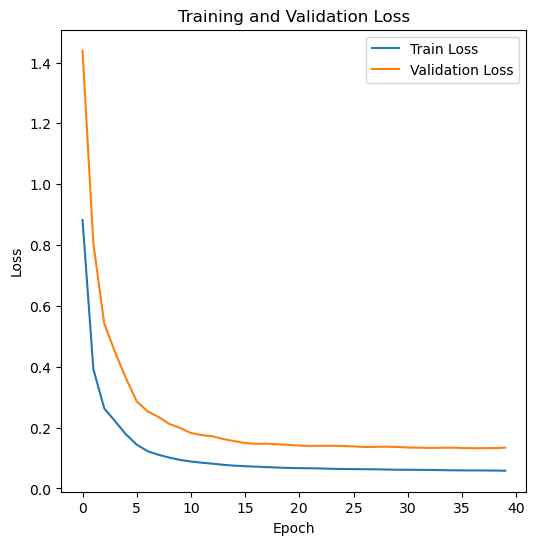

In [55]:
train_losses, val_losses = train_evaluate_model (train_loader, val_loader, model, criterion, optimizer, 40, 5)

plt.figure(figsize=(6,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [56]:
for name, param in model.named_parameters():
    print(name, param)

layers.0.weight Parameter containing:
tensor([[ 5.6537e-01,  9.0029e-02,  1.4426e-01, -6.1910e-03,  6.5673e-02,
         -2.4276e-01, -5.2905e-03,  2.6097e-02,  1.2573e-01, -2.2675e-02,
          1.6250e-01,  2.9897e-01,  2.8986e-01, -1.9921e-01, -1.7163e-01,
         -9.3449e-02,  4.0170e-02,  2.0274e-01,  5.6445e-02,  1.0732e-01,
          5.6253e-02,  7.3569e-02,  6.5983e-02,  1.4551e-01, -7.6433e-03,
         -9.1883e-02,  1.5835e-02, -3.1224e-01, -4.9469e-01, -5.2225e-01,
         -6.0432e-01, -6.5162e-01, -8.3127e-01, -7.9459e-01, -1.3265e-01,
          2.3887e-02, -1.5191e-02, -3.4518e-02,  2.0605e-01,  4.5122e-01,
          3.3958e-01,  2.7484e-01,  3.8785e-01,  4.2734e-01,  5.8297e-01,
          4.8533e-01,  2.6322e-01,  1.4250e-01, -6.5557e-02, -3.8200e-01,
         -3.2814e-01,  1.1011e-01,  1.9075e-01,  1.1188e-01,  9.5992e-02,
          7.1402e-02,  6.8215e-02,  1.7942e-01],
        [ 3.1793e-01, -8.2097e-02, -6.7627e-02,  9.2149e-02, -2.2264e-02,
         -1.1769e-01,  2.

### test model

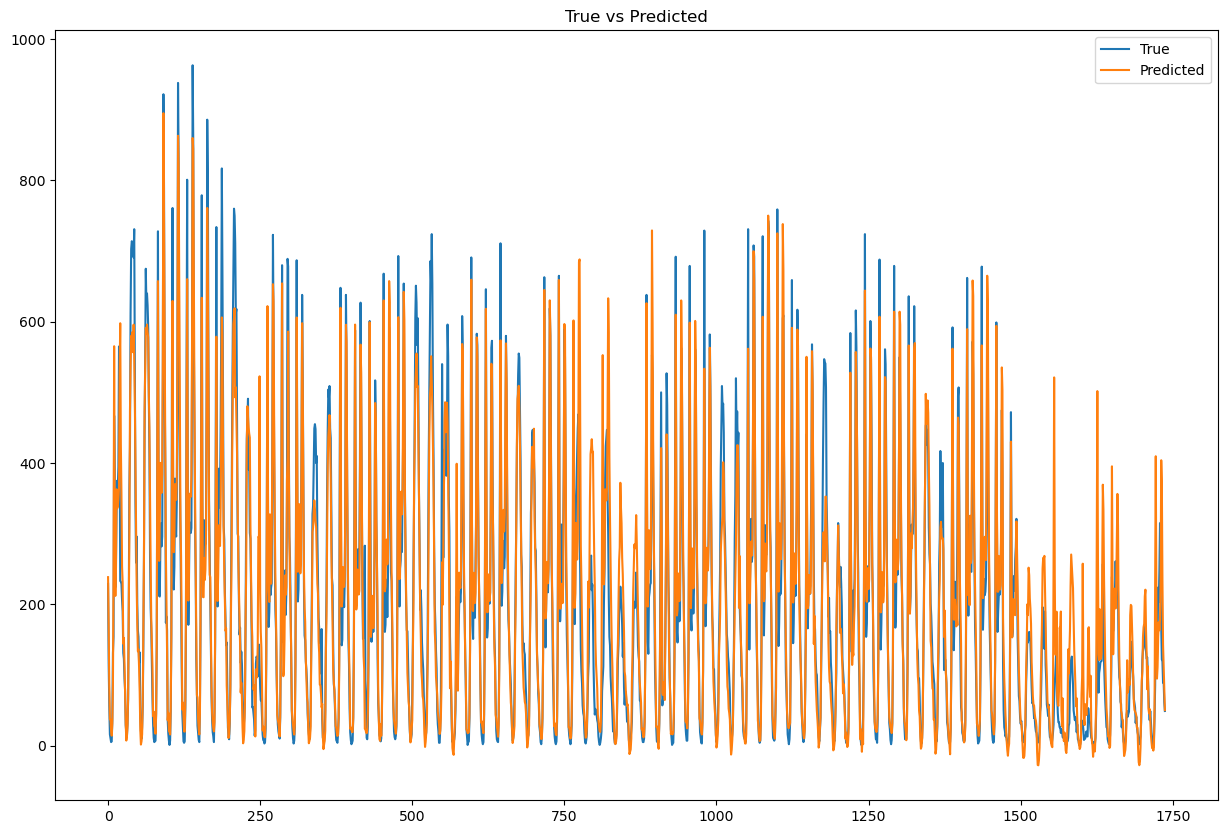

In [57]:
test_loss, true_values, predictions = evaluate_model(test_loader, criterion, model)

target_column = 'cnt'
mean, std = scaled_features[target_column]
predictions = (predictions * std) + mean
        
evaluate_plot(y_test.values, predictions)